## Importing and loading dataset

In [2]:
import os

from bs4 import BeautifulSoup

import pandas as pd
import matplotlib.pyplot as plt

import torch
from transformers import AutoModelForCTC, Wav2Vec2Processor, AutoProcessor, pipeline
import torchaudio.functional as F

import re
from evaluate import load

if os.name == 'posix':
    # Linux
    os.chdir('/home/rodoggx/Documents/iResearch-2024/DATA')
elif os.name == 'nt':
    # Windows
    os.chdir('C:/Users/rowan/OneDrive/Desktop/code/iResearch-2024/DATA')
else:
    print("Unknown operating system")

In [4]:
audioFiles = [f for f in os.listdir() if f.endswith('.wav')]
xmlFiles = []
for i in range(len(audioFiles)):
	xmlFiles.append(audioFiles[i].replace('.wav', '.xml'))

transcripts = []

datasetDict = {
	'audio': audioFiles,
	'transcripts': []
}

for i in range(len(xmlFiles)):
	with open(xmlFiles[i], 'r', encoding='utf-8') as file:
		data = file.read()

	Bs_data = BeautifulSoup(data, "xml")
	b_unique = Bs_data.find_all('text')
	for j in b_unique:
		transcripts.append(j.text)
	datasetDict['transcripts'].append(transcripts)
	transcripts = []

df = pd.DataFrame(datasetDict)

df.to_csv('dataset.csv', index=False)

df


,audio,transcripts
0,LKPR_RUZYNE_Radar_120_520MHz_20201026_205056.wav,[KLM Seven Three Whiskey maintain present head...
1,LKPR_RUZYNE_Tower_134_560MHz_20201025_101021.wav,[Ryan Air Seven Romeo Mike route reaching and ...
2,LZIB_STEFANIK_Tower_118_3MHz_20210505_145115.wav,[Topjet Four Zero Two via delta foxtrot ten th...
3,LKTB_BRNO_Approach-Radar_127_350MHz_20201028_1...,[Oscar Kilo Delta Sierra India turn left headi...
4,LKPR_RUZYNE_Tower_134_560MHz_20201025_204809.wav,[Ruzyne tower Trans Europe Four Two One [Ne Cz...
...,...,...
555,YSSY_SYDNEY_Tower_120_5MHz_20210502_055020.wav,[[#unnamed]tower[/#unnamed] [#unnamed]good[/#u...
556,LSZH_ZURICH_Tower_118_1MHz_20210414_101150.wav,[Hotel Delta Lima contact apron one two one de...
557,YSSY_SYDNEY_Tower_120_5MHz_20210505_124859.wav,[[#command]cleared[/#command] [#command]to[/#c...
558,YSSY_SYDNEY_Tower_120_5MHz_20210501_090436.wav,[Sydney tower evening Qantas Seventy Seven Zer...


## Evaluation

In [5]:
modelsList = [
    'openai/whisper-large-v3',
    'Jzuluaga/wav2vec2-xls-r-300m-en-atc-uwb-atcc-and-atcosim',
    'facebook/wav2vec2-base-960h'
]

resultsData = {
    'Model': modelsList,
    'Average WER': [],
    'Lowest WER': [],
    'Highest WER': [],
    'Values': []
}

wer= load('wer')

for model in modelsList:
    totalWER = 0
    itterations = len(df['audio'])
    lowWER = 1
    highWER = 0
    
    temp = []

    pipe = pipeline("automatic-speech-recognition", model=model)

    for i in range(itterations):
        result = pipe(df['audio'][i])
        transcription = ''

        for j in range(len(df['transcripts'][i])):
            transcription += df['transcripts'][i][j] + ' '

        if transcription.endswith(' '):
            transcription = transcription[:-1]

        transcription = re.sub(r'\[.*?\]', '', transcription)
        transcription = transcription.replace('[', '').replace(']', '')

        transcription = re.sub(r'\s+', ' ', transcription)

        wer_score = wer.compute(predictions=[result['text'].lower()], references=[transcription.lower()])
        temp.append(wer_score)
        print(wer_score)
        totalWER += wer_score
        if wer_score < lowWER:
            lowWER = wer_score
        if wer_score > highWER:
            highWER = wer_score

    averageWER = totalWER / itterations
    print(f"Average WER for {model}: {averageWER}")
    resultsData['Average WER'].append(averageWER)
    resultsData['Lowest WER'].append(lowWER)
    resultsData['Highest WER'].append(highWER)
    resultsData['Values'].append(temp)

resultsDf = pd.DataFrame.from_dict(resultsData, orient='columns')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7948717948717948


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9473684210526315


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6666666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.631578947368421


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8666666666666667


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6666666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.75


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.42857142857142855


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6206896551724138


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9666666666666667


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7142857142857143


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5714285714285714


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7111111111111111


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8636363636363636


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9615384615384616


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9230769230769231


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6875


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7272727272727273


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9142857142857143


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6666666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.2857142857142857


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5833333333333334


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.88


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.4375


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.725


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.35714285714285715


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8888888888888888


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.09090909090909091


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6363636363636364


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9090909090909091


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9090909090909091


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.2857142857142857


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6666666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8275862068965517


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9285714285714286


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.34782608695652173


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9285714285714286


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5652173913043478


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.42857142857142855


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5833333333333334


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.4375


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7142857142857143


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8636363636363636


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8181818181818182


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7857142857142857


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5454545454545454


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7857142857142857


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6470588235294118


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.15789473684210525


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.47058823529411764


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6666666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7272727272727273


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.75


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.75


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5357142857142857


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5882352941176471


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.55


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8484848484848485


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8095238095238095


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6923076923076923


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.875


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9375


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6666666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.4782608695652174


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.618421052631579


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8461538461538461


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.65


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7142857142857143


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7333333333333333


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.45454545454545453


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7142857142857143


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6666666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.2857142857142858


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.26666666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.875


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5925925925925926


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7948717948717948


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8148148148148148


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9444444444444444


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9130434782608695


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7272727272727273


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5925925925925926


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7142857142857143


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7692307692307693


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.3333333333333333


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6666666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.813953488372093


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9375


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7272727272727273


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7647058823529411


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.30434782608695654


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6470588235294118


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.75


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9310344827586207


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6470588235294118


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8666666666666667


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.42857142857142855


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.3333333333333333


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5555555555555556


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8666666666666667


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6363636363636364


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5333333333333333


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7142857142857143


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6875


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.42857142857142855


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6923076923076923


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7272727272727273


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.35135135135135137


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7777777777777778


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6744186046511628


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7407407407407407


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.625


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.45454545454545453


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.375


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9230769230769231


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.5454545454545454


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.1666666666666667


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5769230769230769


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7272727272727273


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.75


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7222222222222222


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6363636363636364


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.96


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.85


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8620689655172413


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.46153846153846156


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7058823529411765


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.17391304347826086


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.625


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6875


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6842105263157895


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8823529411764706


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6666666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.2142857142857142


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.46153846153846156


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8181818181818182


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6666666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.75


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7894736842105263


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6923076923076923


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8947368421052632


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.375


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9285714285714286


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6363636363636364


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8695652173913043


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7083333333333334


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.47368421052631576


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8484848484848485


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.95


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5263157894736842


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.875


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5789473684210527


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9090909090909091


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8235294117647058


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8888888888888888


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5161290322580645


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6153846153846154


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.639344262295082


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6153846153846154


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.3


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8181818181818182


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6153846153846154


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.896551724137931


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8125


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.48


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.3157894736842105


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7714285714285715


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6086956521739131


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.26666666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.85


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8125


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6956521739130435


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8461538461538461


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.84


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5263157894736842


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.75


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8823529411764706


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9259259259259259


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5454545454545454


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7272727272727273


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6666666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.64


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8947368421052632


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8461538461538461


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5263157894736842


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.75


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9714285714285714


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.45454545454545453


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7735849056603774


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7692307692307693


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6944444444444444


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9090909090909091


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.4444444444444444


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9347826086956522


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7575757575757576


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.3


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7575757575757576


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6585365853658537


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


12.827586206896552


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8181818181818182


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.4166666666666667


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6818181818181818


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.3548387096774194


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6363636363636364


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


5.333333333333333


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.71875


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7272727272727273


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.625


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6470588235294118


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8125


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7727272727272727


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.23076923076923078


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6666666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.8596491228070176


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.44


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.75


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6153846153846154


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.4117647058823529


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9090909090909091


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.3448275862068966


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5454545454545454


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0833333333333333


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.75


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.88


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6428571428571429


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.1666666666666667


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5833333333333334


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7142857142857143


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7777777777777778


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5714285714285714


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.625


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7142857142857143


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.375


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9230769230769231


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.65


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9090909090909091


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5714285714285714


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6190476190476191


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8205128205128205


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6190476190476191


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7727272727272727


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5384615384615384


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.875


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7678571428571429


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8125


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9545454545454546


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.45454545454545453


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6666666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7727272727272727


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.42857142857142855


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8275862068965517


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.2727272727272727


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7272727272727273


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6666666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.3


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7058823529411765


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8888888888888888


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7647058823529411


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.375


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.625


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.18181818181818182


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7692307692307693


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6363636363636364


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5333333333333333


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.625


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6153846153846154


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7083333333333334


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5833333333333334


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8947368421052632


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.22727272727272727


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8461538461538461


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9285714285714286


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6666666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7560975609756098


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6666666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.875


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.3333333333333333


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.72


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8947368421052632


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6875


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.4166666666666667


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.4285714285714286


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6666666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8181818181818182


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.782608695652174


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5714285714285714


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8823529411764706


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8181818181818182


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7222222222222222


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7142857142857143


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.2


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5135135135135135


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9090909090909091


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.3333333333333333


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6785714285714286


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5833333333333334


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7307692307692307


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9166666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8181818181818182


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7931034482758621


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8333333333333334


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9166666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6363636363636364


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9230769230769231


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.3684210526315789


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9285714285714286


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8181818181818182


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5454545454545454


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.4375


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7096774193548387


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.625


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7692307692307693


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6774193548387096


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.64


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8571428571428571


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.96875


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.25


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6666666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5483870967741935


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9230769230769231


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9375


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7142857142857143


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9714285714285714


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.46153846153846156


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.4782608695652174


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.2727272727272727


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7777777777777778


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8181818181818182


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7272727272727273


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.35714285714285715


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6428571428571429


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5909090909090909


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7222222222222222


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.14285714285714285


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.875


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9375


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8333333333333334


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7222222222222222


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7272727272727273


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9090909090909091


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7692307692307693


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6111111111111112


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8125


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0833333333333333


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9444444444444444


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9333333333333333


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7142857142857143


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8666666666666667


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6842105263157895


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.4


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6428571428571429


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.75


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5333333333333333


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.42857142857142855


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8666666666666667


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7142857142857143


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8461538461538461


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.4782608695652174


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5714285714285714


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5294117647058824


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9333333333333333


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9230769230769231


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6923076923076923


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7272727272727273


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.3181818181818182


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8181818181818182


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6829268292682927


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7272727272727273


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8666666666666667


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0476190476190477


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.34615384615384615


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6428571428571429


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.3333333333333333


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5769230769230769


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5555555555555556


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7272727272727273


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5833333333333334


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7142857142857143


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6666666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.75


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5925925925925926


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5757575757575758


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8823529411764706


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8333333333333334


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7058823529411765


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.875


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5909090909090909


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.3333333333333333


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.2


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7857142857142857


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.75


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7948717948717948


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7894736842105263


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7105263157894737


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6923076923076923


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.68


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.18181818181818182


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.36363636363636365


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.45454545454545453


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.4666666666666667


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7777777777777778


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5882352941176471


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6923076923076923


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7142857142857143


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.3076923076923077


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.3125


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6923076923076923


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6875


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.45


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5294117647058824


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.782608695652174


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8666666666666667


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6923076923076923


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6666666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7555555555555555


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.625


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6363636363636364


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6363636363636364


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5238095238095238


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.4


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9459459459459459


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.21428571428571427


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.3333333333333333


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6666666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8333333333333334


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6923076923076923


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8235294117647058


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.625


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5263157894736842


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.2777777777777778


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.1875


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8235294117647058


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7272727272727273


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5652173913043478


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8571428571428571


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.46875


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6111111111111112


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.75


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7058823529411765


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.92


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.125


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.4666666666666667


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6190476190476191


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9090909090909091


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7272727272727273


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6666666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9166666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.875


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8333333333333334


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7058823529411765


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7272727272727273


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9285714285714286


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8181818181818182


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6363636363636364


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5833333333333334


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7857142857142857


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8333333333333334


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9090909090909091


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.5454545454545454


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8333333333333334


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8235294117647058


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8461538461538461


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.75


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6923076923076923


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5833333333333334


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.46153846153846156
Average WER for openai/whisper-large-v3: 0.747769969644258


Some weights of the model checkpoint at Jzuluaga/wav2vec2-xls-r-300m-en-atc-uwb-atcc-and-atcosim were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at Jzuluaga/wav2vec2-xls-r-300m-en-atc-uwb-atcc-and-atcosim and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrization

0.2
0.5641025641025641
0.3157894736842105
0.23809523809523808
0.35135135135135137
0.3684210526315789
0.26666666666666666
0.13333333333333333
0.5
0.6666666666666666
1.0
0.41379310344827586
0.6333333333333333
0.5
0.42857142857142855
0.4444444444444444
0.36363636363636365
0.19230769230769232
0.07692307692307693
0.7
0.4375
0.5
0.7142857142857143
0.5
0.35294117647058826
0.47619047619047616
0.9166666666666666
0.52
0.40625
0.475
0.42857142857142855
0.6666666666666666
0.5454545454545454
0.36363636363636365
0.5833333333333334
0.55
0.2727272727272727
0.7272727272727273
0.5
0.5555555555555556
0.5517241379310345
0.14285714285714285
0.43478260869565216
0.75
0.7142857142857143
1.0
0.6521739130434783
0.5714285714285714
0.2
0.75
0.5
0.7857142857142857
0.45
0.3181818181818182
0.7333333333333333
0.36363636363636365
0.7857142857142857
0.2727272727272727
0.42857142857142855
0.058823529411764705
0.7368421052631579
0.8235294117647058
0.2
0.5454545454545454
0.75
0.75
0.5714285714285714
0.47058823529411764
0.

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You sho

0.92
0.9487179487179487
1.0
0.9523809523809523
0.972972972972973
1.0
0.9333333333333333
1.0
0.8333333333333334
1.0
1.0
0.8620689655172413
1.0333333333333334
1.1428571428571428
1.1904761904761905
1.0222222222222221
0.9545454545454546
0.9230769230769231
1.0
1.4
0.90625
1.0
0.9714285714285714
1.0
0.9411764705882353
0.8095238095238095
0.9166666666666666
0.92
0.6875
0.775
0.6428571428571429
1.1111111111111112
0.8181818181818182
0.9090909090909091
1.0
0.9
1.0
1.0
1.0
0.8888888888888888
0.9310344827586207
0.8571428571428571
0.5652173913043478
1.0
1.0
1.0
0.5652173913043478
1.1428571428571428
1.55
1.0
1.0
1.0
0.95
1.0
1.0666666666666667
1.0
1.0
1.1818181818181819
1.0
0.8235294117647058
0.6842105263157895
0.7647058823529411
0.8
0.9090909090909091
1.25
1.25
1.0357142857142858
1.0
0.55
0.9393939393939394
0.9523809523809523
1.0769230769230769
0.9375
0.9
1.0
1.0
0.9333333333333333
1.0
1.013157894736842
0.9
0.75
1.0
1.25
0.6428571428571429
0.8
1.0
0.6363636363636364
0.8571428571428571
0.980392156862

In [9]:
resultsDf

,Model,Average WER,Lowest WER,Highest WER,Values
0,openai/whisper-large-v3,0.747770,0.090909,12.827586,"[1.0, 0.7948717948717948, 0.9473684210526315, ..."
1,Jzuluaga/wav2vec2-xls-r-300m-en-atc-uwb-atcc-a...,0.501100,0.000000,1.818182,"[0.2, 0.5641025641025641, 0.3157894736842105, ..."
2,facebook/wav2vec2-base-960h,0.932565,0.250000,1.550000,"[0.92, 0.9487179487179487, 1.0, 0.952380952380..."


## Plotting

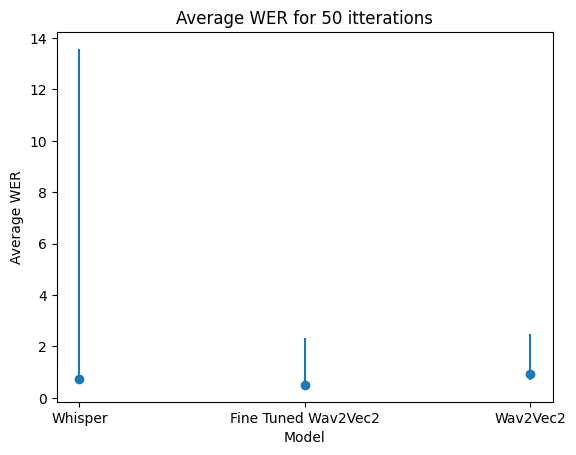

In [7]:
modelNames = [
    'Whisper',
    'Fine Tuned Wav2Vec2',
    'Wav2Vec2'

]

plt.errorbar(
    modelNames,
    resultsDf['Average WER'],
    yerr=[resultsDf['Lowest WER'], resultsDf['Highest WER']],
    fmt='o'
)

plt.xlabel('Model')
plt.ylabel('Average WER')

plt.title('Average WER for 50 itterations')

plt.show()